# Decision trees

![img](https://pbs.twimg.com/media/B13n2VVCIAA0hJS.jpg)

In [43]:
import numpy as np
import matplotlib.pyplot as plt

Let's generate a toy dataset:

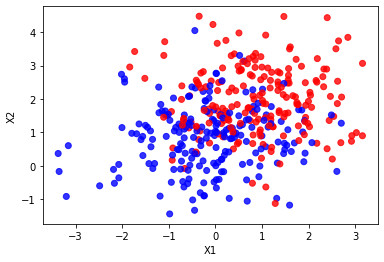

In [44]:
from sklearn.datasets import make_blobs

X_toy, y_toy = make_blobs(n_samples=400,
                          centers=[[0., 1.], [1., 2.]],
                          random_state=14)

plt.scatter(X_toy[:, 0], X_toy[:, 1], c=y_toy, alpha=0.8, cmap='bwr')
plt.xlabel('X1'), plt.ylabel('X2');

## Decision trees out of the box

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

DecisionTreeClassifier has a number of parameters:
* `max_depth` – a limit on tree depth (default – no limit)
* `min_samples_split` – there should be at least this many samples to split further (default – 2)
* `min_samples_leaf` – there should be at least this many samples on one side of a split to consider it valid (default – 1).
* `criterion` – 'gini' or 'entropy' – split stuff over this parameter (default : gini)

In [46]:
clf = DecisionTreeClassifier(max_depth=2)
clf.fit(X_toy, y_toy)

DecisionTreeClassifier(max_depth=2)

### Plot decision surface

Here's a function that makes a 2d decision boundary plot for a given classifier:

In [47]:
from sklearn.metrics import accuracy_score

def plot_decision_surface(
                  clf, X, y,
                  nx=200, ny=100,
                  cmap='bwr',
                  alpha=0.6,
        ):
    """
    Plot the decision boundary of clf on X and y, visualize training points
    """
    
    # Define the grid
    x_top_left = X.min(axis=0) - 1
    x_bottom_right = X.max(axis=0) + 1
    grid_x0, grid_x1 = np.meshgrid(
         np.linspace(x_top_left[0], x_bottom_right[0], ny),
         np.linspace(x_top_left[1], x_bottom_right[1], nx)
      )
    
    # Calculate predictions on the grid
    y_pred_grid = clf.predict(
                        np.stack(
                              [
                                grid_x0.ravel(),
                                grid_x1.ravel()
                              ],
                              axis=1
                            )
                      ).reshape(grid_x1.shape)
    
    # Find optimal contour levels and make a filled
    # contour plot of predictions
    labels = np.sort(np.unique(y))
    labels = np.concatenate([[labels[0] - 1],
                             labels,
                             [labels[-1] + 1]])
    medians = (labels[1:] + labels[:-1]) / 2
    plt.contourf(grid_x0, grid_x1, y_pred_grid, cmap=cmap, alpha=alpha,
                 levels=medians)
    
    # Scatter data points on top of the plot,
    # with different styles for correct and wrong
    # predictions
    y_pred = clf.predict(X)
    plt.scatter(*X[y_pred==y].T, c=y[y_pred==y],
                marker='o', cmap=cmap, s=10, label='correct')
    plt.scatter(*X[y_pred!=y].T, c=y[y_pred!=y],
                marker='x', cmap=cmap, s=50, label='errors')

    # Dummy plot call to print the accuracy in the legend.
    plt.plot([], [], ' ',
             label='Accuracy = {:.3f}'.format(accuracy_score(y, y_pred)))
    
    plt.legend(loc='best')

Let's apply it to the tree we've fitted above:

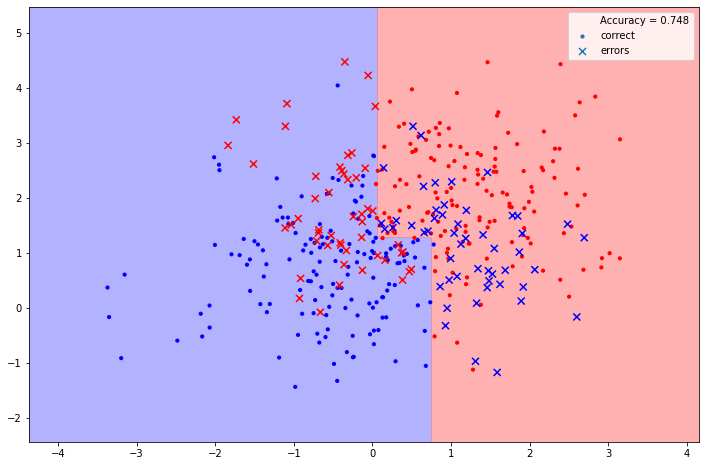

In [48]:
plt.figure(figsize=(12, 8))
plot_decision_surface(clf, X_toy, y_toy)

### Tree depth

First we are going to split our data to train and test subsets:

In [49]:
X_toy_train, X_toy_test, y_toy_train, y_toy_test = \
    train_test_split(X_toy, y_toy, test_size=0.25)

Now it's your turn to investigate how the decision boundary depends on the tree depth. Maximum tree depth is defined by the `max_depth` parameter. Try out the following values: `[1, 2, 3, 5, 10]`. Make decision boundary plots for both train and test datasets (separately).

  > *Hint: you can make a nice plot with multiple columns and rows (see example below).*
  
```python
plt.figure(figsize=(width, height))
for i in range(num_rows * num_columns):
  plt.subplot(num_rows, num_columns, i + 1)
  # subplot numbering starts from 1   ^^^
  
  # ...
  # (do the plotting)
plt.show();
```

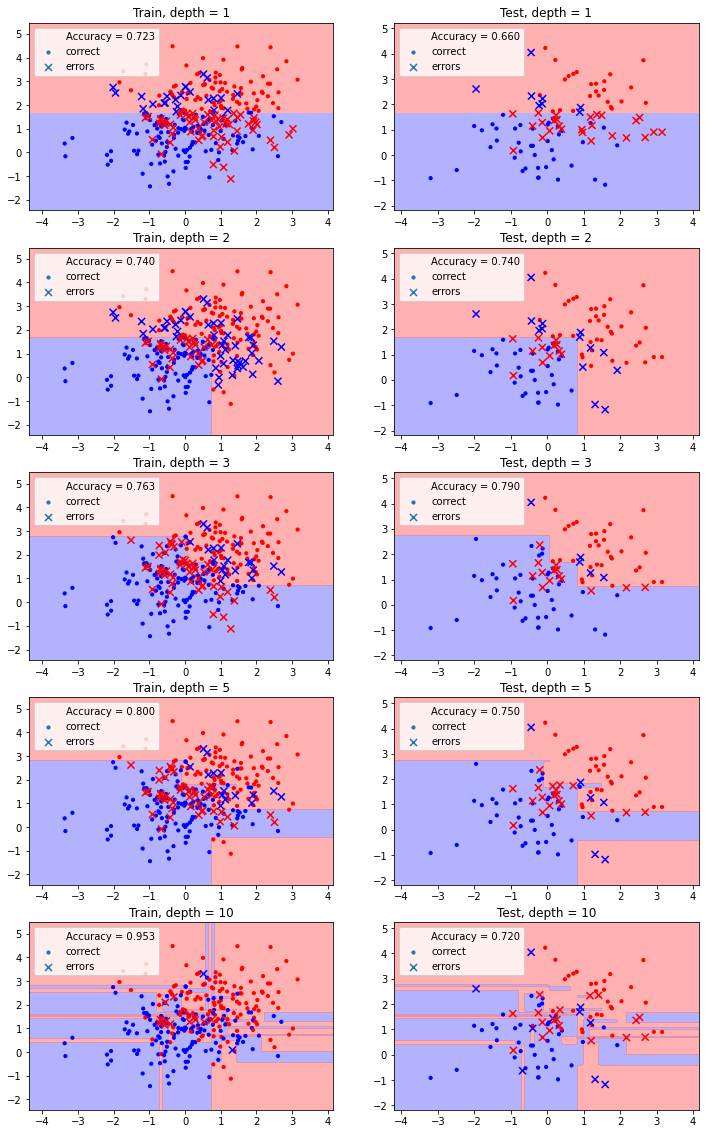

In [50]:
depth_values = [1, 2, 3, 5, 10]


plt.figure(figsize=(12, 4 * len(depth_values)))
for i, depth in enumerate(depth_values):
    clf = DecisionTreeClassifier(max_depth=depth).fit(X_toy_train, y_toy_train)
    plt.subplot(len(depth_values), 2, 2 * i + 1)
    plot_decision_surface(clf, X_toy_train, y_toy_train)
    plt.title(f"Train, depth = {depth}")
    plt.subplot(len(depth_values), 2, 2 * i + 2)
    plot_decision_surface(clf, X_toy_test, y_toy_test)
    plt.title(f"Test, depth = {depth}")
    

### Toy multiclass data

Now let's try out a multiclass classification case:

In [51]:
!wget https://github.com/HSE-LAMBDA/MLatFIAN2021/raw/main/seminar06/data.npz

--2021-11-10 13:57:54--  https://github.com/HSE-LAMBDA/MLatFIAN2021/raw/main/seminar06/data.npz
Распознаётся github.com (github.com)... 140.82.121.4
Подключение к github.com (github.com)|140.82.121.4|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 302 Found
Адрес: https://raw.githubusercontent.com/HSE-LAMBDA/MLatFIAN2021/main/seminar06/data.npz [переход]
--2021-11-10 13:57:55--  https://raw.githubusercontent.com/HSE-LAMBDA/MLatFIAN2021/main/seminar06/data.npz
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 200 OK
Длина: 108474 (106K) [application/octet-stream]
Сохранение в каталог: ««data.npz.2»».

data.npz.2          100%[===================>] 105,93K  --.-KB/s    за 0,07s   

2021-11-10 13:57:55 (1,41 MB/s) - «data.npz.2» сохра

Firstly, we'll load the data:

In [52]:
data = np.load('data.npz')
X, y = data["X"], data["y"]

print(X.shape, y.shape)

(4505, 2) (4505,)


And then split it to train and test:

In [53]:
np.unique(y)

array([0, 1, 2, 3, 4])

In [54]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.5, random_state=1337)

Now it's your turn to have a look at the data. Make a 2d scatter plot of the data points.

 > *Hint: instead of calling `scatter` separately for each class, you can give it a vector of color index values through the `c` parameter (`scatter(x0, x1, c=y, cmap='rainbow'`). The 'rainbow' colormap gives good enough color diversity for the multiclass case.*

(2253, 2)

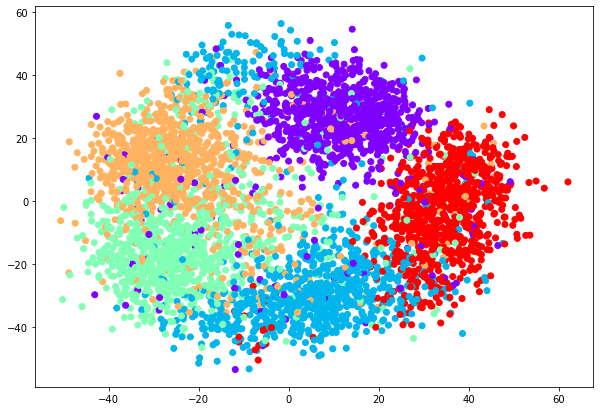

In [55]:
plt.figure(figsize=(10, 7))
plt.scatter(*X.T, c=y, cmap="rainbow");

Now that we've had a look at the data, let's fit a decision tree on it:

In [56]:
clf = DecisionTreeClassifier(min_samples_leaf=5)
clf.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=5)

and plot the result:

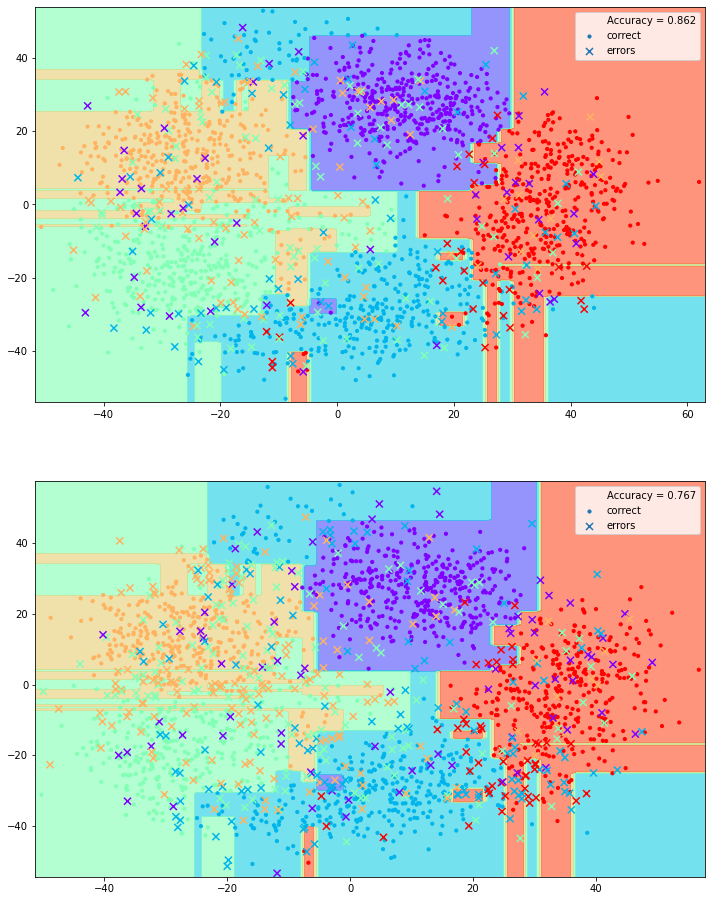

In [57]:
plt.figure(figsize=(12, 16))
plt.subplot(2, 1, 1)
plot_decision_surface(clf, X_train, y_train, cmap='rainbow')
plt.subplot(2, 1, 2)
plot_decision_surface(clf, X_test, y_test, cmap='rainbow');

```

```

```

```

```

```

```

```

#### We need a better tree!

Try adjusting the parameters of DecisionTreeClassifier to improve the test accuracy.
 * Accuracy >= 0.72 - not bad for a start
 * Accuracy >= 0.75 - better, but not enough
 * Accuracy >= 0.77 - pretty good
 * Accuracy >= 0.78 - great! (probably the best result for a single tree)
 
Feel free to modify the DecisionTreeClassifier above instead of re-writing everything.

**Note:** some of the parameters you can tune are under the "Decision trees out of the box" header.

## Feature transformations
Try adding feature transformations using a pipeline and a transformation, e.g. function transformer:
```python
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

clf = make_pipeline(
    FunctionTransformer(lambda X: np.concatenate([X, X**2], axis=1)),
    DecisionTreeClassifier()
)
```

Which transformations should improve the score?

In [110]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

clf = make_pipeline(
    FunctionTransformer(lambda X: np.concatenate([X,X**2],axis = 1)),
    DecisionTreeClassifier(min_samples_leaf=5,max_depth=5)
)


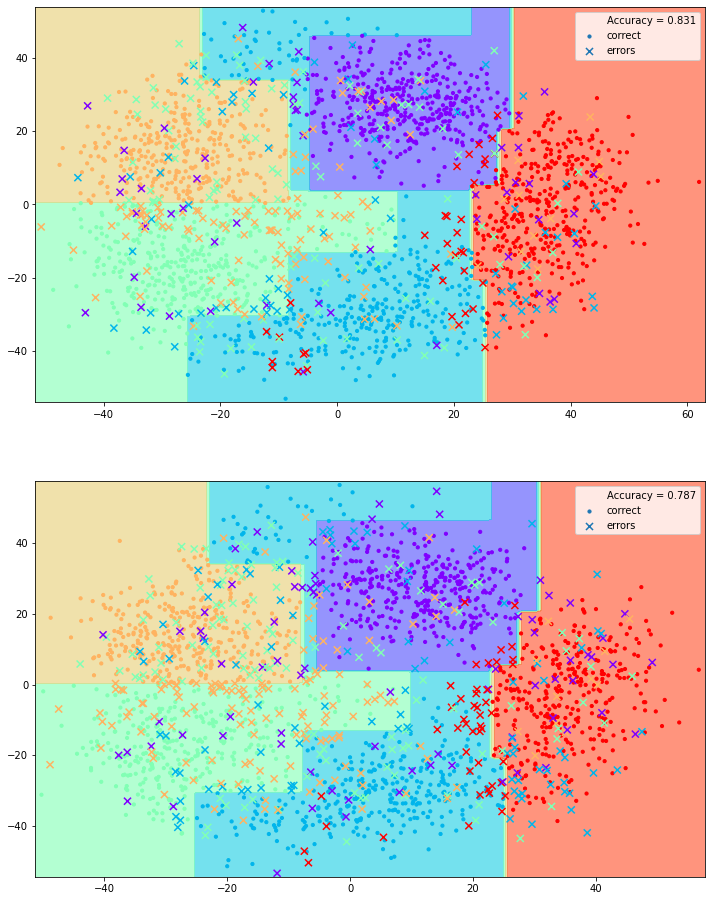

In [111]:
clf.fit(X_train, y_train)

plt.figure(figsize=(12, 16))
plt.subplot(2, 1, 1)
plot_decision_surface(clf, X_train, y_train, cmap='rainbow')
plt.subplot(2, 1, 2)
plot_decision_surface(clf, X_test, y_test, cmap='rainbow');

```
```
```
```

Отличная accuracy, больше 0.78.

We've talked a lot about the importance of feature scaling. Why aren't we doing it here?

Try adding a standard scaler to the pipeline of your best model and check how it affects the result. Can you explain the result?

Добавлю Robust Scaling, который использовался в прошлых домашках.

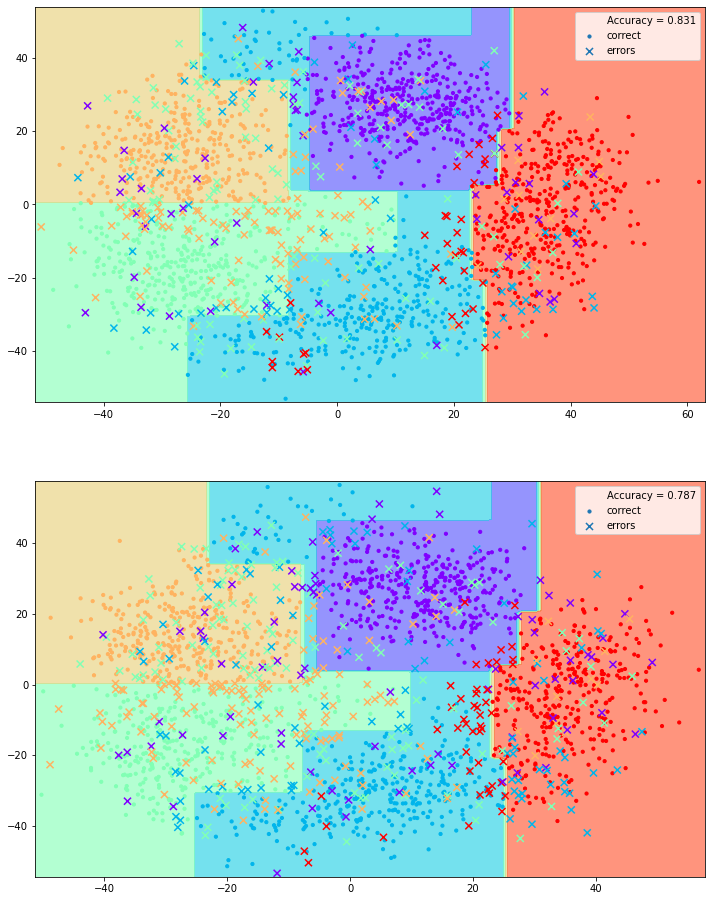

In [112]:
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(
    StandardScaler(),
    FunctionTransformer(lambda X: np.concatenate([X,X**2],axis = 1)),
    DecisionTreeClassifier(min_samples_leaf=5,max_depth=5)
)

clf.fit(X_train, y_train)

plt.figure(figsize=(12, 16))
plt.subplot(2, 1, 1)
plot_decision_surface(clf, X_train, y_train, cmap='rainbow')
plt.subplot(2, 1, 2)
plot_decision_surface(clf, X_test, y_test, cmap='rainbow');


```
```
```
```

Ничего не изменилось, и это объяснимо. Дело в том, что в узлах дерева условия, которые разделяют наши параметры (высекают некоторые группы операциями > и <). При применении Robust меняется масштаб, плотность точек в пространстве признаков увеличивается, что важно для других моделей. Однако относительный порядок признаков не при масштабировании не меняется, поэтому метод бинарного разделения (если можно это так назвать) работает точно так же.

# Tree pruning (Minimal Cost-Complexity)

Let tree $T$ have the total weighted sample impurity of the terminal nodes $R(T)$.

Can prune the tree by minimizing:
$$R_\alpha(T) = R(T) + \alpha\left|T\right|,$$
where $\alpha\geq0$, and $\left|T\right|$ is the number of terminal nodes in the tree.

Let $T_t$ be the subtree tree whose root node is $t\in T$.

$T_t$ will be pruned out (i.e. replaced with $t$ as the terminal node) if:
$$R(t)+\alpha < R(T_t)+\alpha\left|T_t\right|$$
or in other words if:
$$\alpha > \alpha_{eff}(t)=\frac{R(t) - R(T_t)}{\left|T_t\right|-1}$$

One can use the `cost_complexity_pruning_path` method of `DecisionTreeClassifier` to get the list of $\alpha_{eff}$.

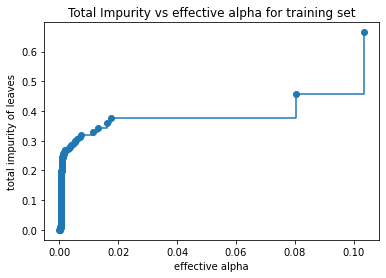

In [118]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

path = clf.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities


plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")
plt.title("Total Impurity vs effective alpha for training set");

Your turn! `DecisionTreeClassifier` has a `ccp_alpha` parameter to prune the tree.

 For each of the `ccp_alphas` defined above fit a tree, and then make 3 plots:
 - tree depth vs alpha
 - number of nodes in the tree vs alpha
 - train and test accuracies vs alpha

You can get the tree depth with `clf.tree_.max_depth`, and number of nodes with `clf.tree_.node_count`.

Text(0, 0.5, 'tree depth')

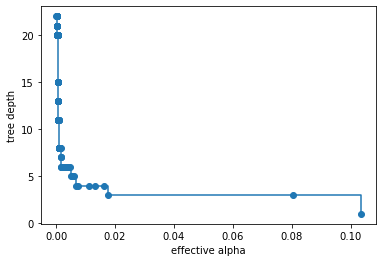

In [144]:
tree_depth = []
num_nodes = []
test_accuracy = []
train_accuracy = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=alpha)
    clf.fit(X_train, y_train)
    tree_depth.append(clf.tree_.max_depth)
    num_nodes.append(clf.tree_.node_count)
    
    test_y_pred = clf.predict(X_test)
    test_accuracy.append((test_y_pred == y_test).mean())
    
    train_y_pred = clf.predict(X_train)
    train_accuracy.append((train_y_pred == y_train).mean())
    
plt.plot(ccp_alphas[:-1], np.array(tree_depth)[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("effective alpha")
plt.ylabel("tree depth")

Text(0, 0.5, 'number of nodes')

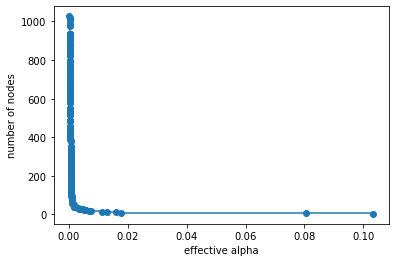

In [145]:
plt.plot(ccp_alphas[:-1], np.array(num_nodes)[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("effective alpha")
plt.ylabel("number of nodes")

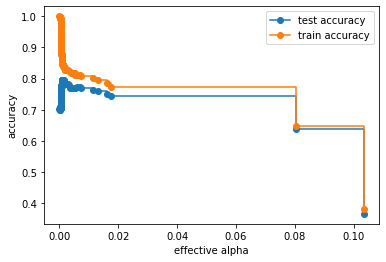

In [146]:
plt.plot(ccp_alphas[:-1], np.array(test_accuracy)[:-1],marker='o', drawstyle="steps-post",label = 'test accuracy')
plt.plot(ccp_alphas[:-1], np.array(train_accuracy)[:-1],marker='o', drawstyle="steps-post",label = 'train accuracy')
plt.xlabel("effective alpha")
plt.ylabel("accuracy")
plt.legend()

# Visualizing a tree

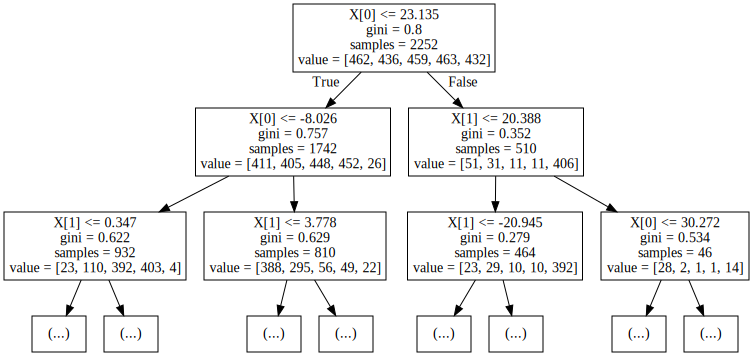

In [116]:
import pydot_ng
import io

from sklearn.tree import export_graphviz
from IPython.display import SVG


def plot_tree(tree, max_depth, columns=None):
  buf = io.StringIO()
  export_graphviz(tree, out_file=buf,
                  feature_names=columns,
                  max_depth=max_depth)
  graph = pydot_ng.graph_from_dot_data(buf.getvalue())
  return SVG(graph.create_svg())

plot_tree(clf, max_depth=2)